In [1]:
%load_ext autoreload

In [447]:
%autoreload
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from gpt.model import SinusoidalEmbedding, RevIN, SelfAttention, CrossAttention, MLP
# from gpt.utils import flatten, nparams
from gpt.ts import TSTransformer
# from einops import rearrange
# import torch.optim as optim
# from tqdm.auto import tqdm

In [399]:
xs = torch.tensor(np.linspace(0, 20, 50), dtype=torch.float32)

num_series = 1_100
std = 0.5
_ys = np.random.normal(size=(num_series, x.size)) * std + np.sin(x) + np.random.normal(size=(num_series, 1)) * 5
ys = torch.from_numpy(_ys).reshape(num_series, -1, 1).to(torch.float32)

[[<matplotlib.lines.Line2D at 0x1504f5019090>],

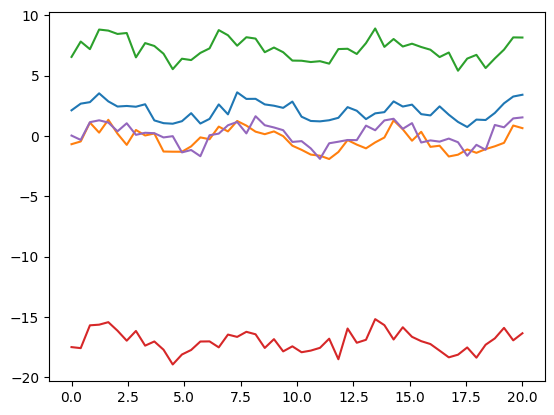

In [400]:
[plt.plot(x, (ys[i,:,0])) for i in range(5)]

In [429]:
tst = TSTransformer(
    input_dim=1,
    embed_dim=64,
    num_layers=2,
    num_heads=4,
    mlp_ratio=4,
    dropout=0.1,
    min_period=0.1,
    max_period=10,
).cuda()

In [430]:
optimizer = optim.AdamW(tst.parameters(), lr=1e-3)

In [431]:
xsc, ysc = xs.cuda(), ys.cuda()
losses = []

for e in (pbar := tqdm(range(500))):
    optimizer.zero_grad()
    out = tst(xsc[:-1], ysc[:1000,:-1,:])
    loss = F.mse_loss(out, ysc[:1000,1:,:])
    losses.append(loss.item())
    pbar.set_description(f"epoch {e} | loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

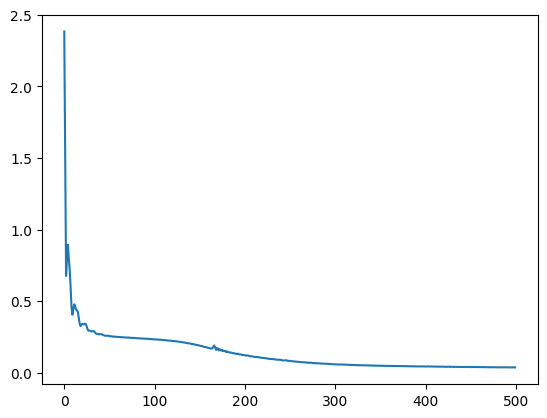

In [432]:
plt.plot(losses)

## next step prediction

In [433]:
out = tst(xsc[:-1], ysc[1000:,:-1,:]).detach().cpu()

/tmp/ipykernel_3473722/2103842444.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')


[[<matplotlib.lines.Line2D at 0x150514c93410>],

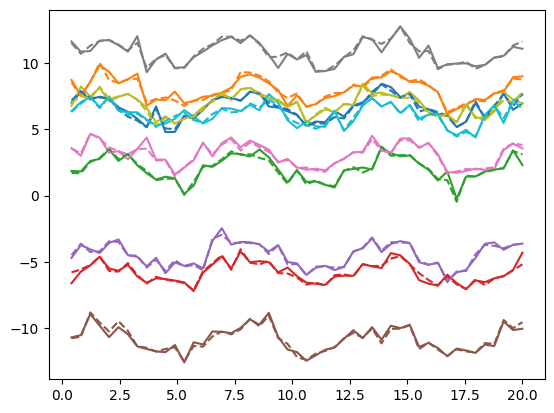

In [434]:
colors = plt.cm.get_cmap('tab20')

[plt.plot(x[1:], ys[1000+i,1:,0], c=colors(i / 10)) for i in range(10)]
[plt.plot(x[1:], out[i,:,0], ls='--', c=colors(i / 10)) for i in range(10)]

In [456]:
with torch.inference_mode():
    out = tst.forecast(xsc, ysc[1000:,:20,:]).cpu()

[[<matplotlib.lines.Line2D at 0x1505f876b790>],

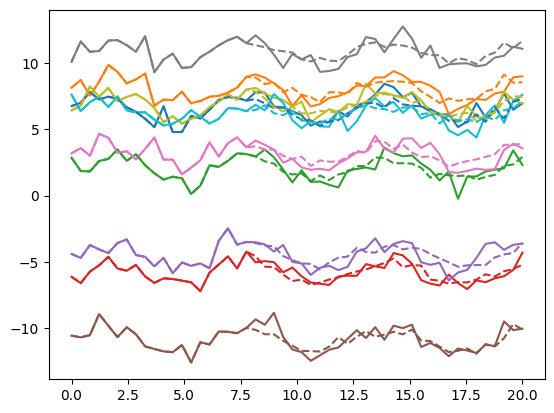

In [458]:
[plt.plot(x, ys[1000+i,:,0], c=colors(i / 10)) for i in range(10)]
[plt.plot(x, out[i,:,0], ls='--', c=colors(i / 10)) for i in range(10)]